###  Imports:

In [76]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque

%matplotlib inline

### Camera Calibration 1: 

This is pretty much the same calibration technique taught in the course.  I pretty much pulled this code directly from the OpenCV online library, the link is below

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html

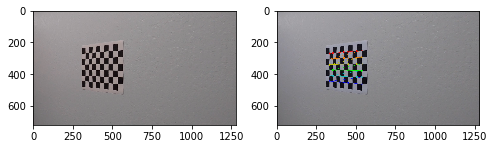

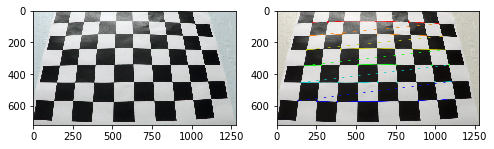

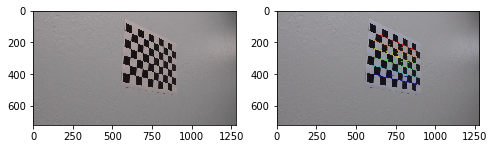

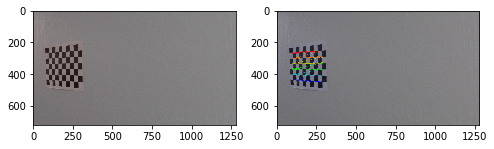

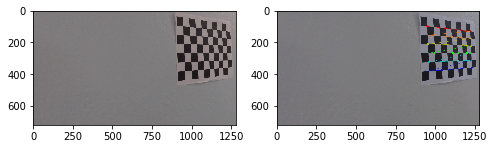

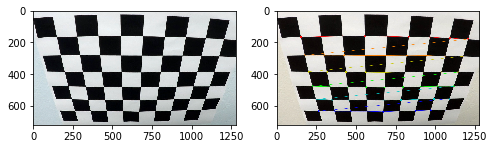

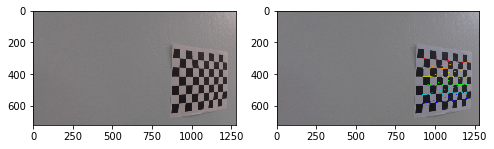

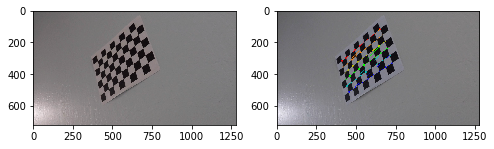

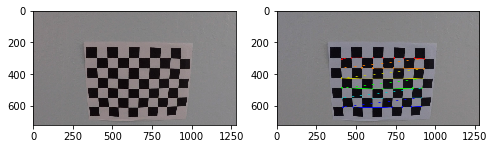

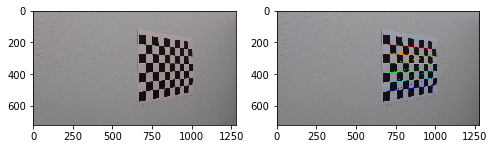

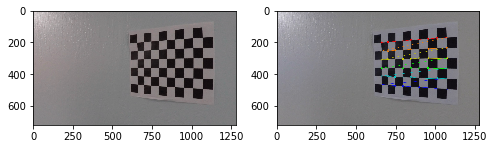

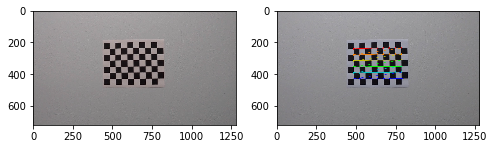

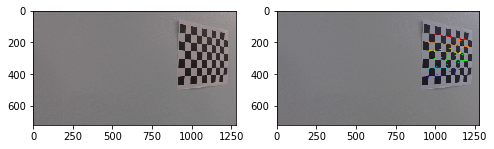

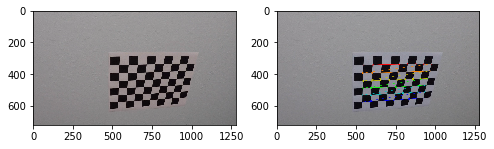

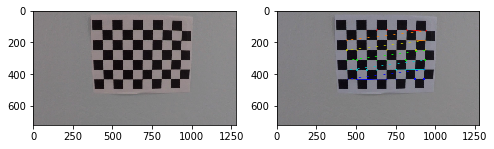

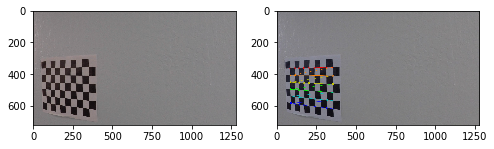

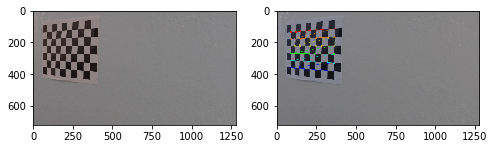

In [77]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# 3d points in real world space
objpoints = [] 

# 2d points in image plane.
imgpoints = [] 

#calibration image glob
images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, and image points
    if (ret):
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Image Preprocessing Functions:

In [88]:
# Remove distortion from images
def undistort(image, show=True, read = True):
    if (read):
        img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if (show):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    else:
        return undist
    
# Perform perspective transform
def birds_eye(img, display=True, read = True):
    if (read):
        undist = undistort(img, show = False)
    else:
        undist = undistort(img, show = False, read=False) 
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    if (display):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M
    
    # Create binary thresholded images to isolate lane line pixels
def apply_thresholds(image, show=True):
    img, M = birds_eye(image, display = False)

    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > 179) & (s_channel < 256)] = 1

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel > 154) & (b_channel < 201)] = 1
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > 224) & (l_channel < 256)] = 1

    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    if (show):
        # Plotting thresholded images
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=12)
        ax1.imshow(cv2.cvtColor(undistort(image, show=False),cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image', fontsize=12)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))

        ax3.set_title('Binary Thresholds', fontsize=12)
        ax3.imshow(combined_binary, cmap='gray')    
        
    else: 
        return combined_binary

###  Pipeline (single images) 1:

Example of distortion-corrected images.

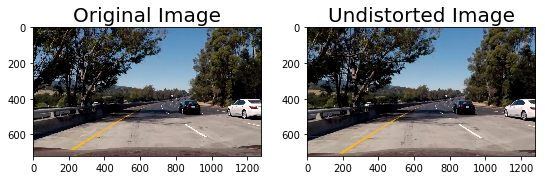

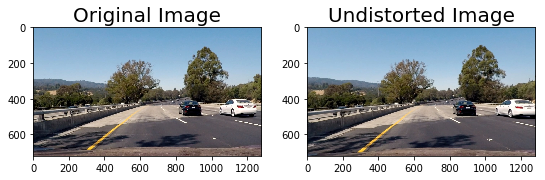

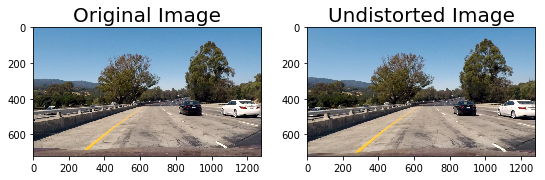

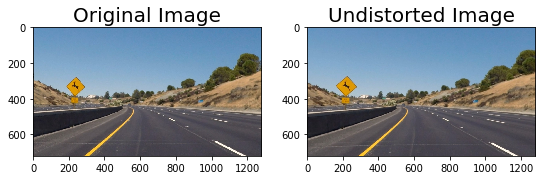

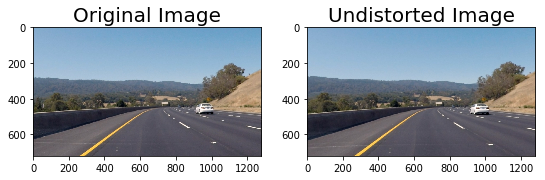

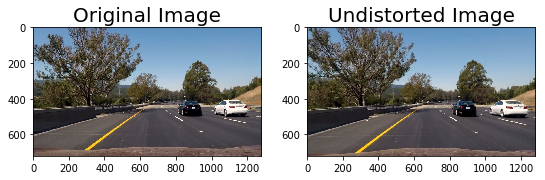

In [89]:
images = glob.glob('test_images_in/test*.jpg')
for image in images:
    undistort(image)

### Pipeline (single images) 2:

Example of my binary image result.

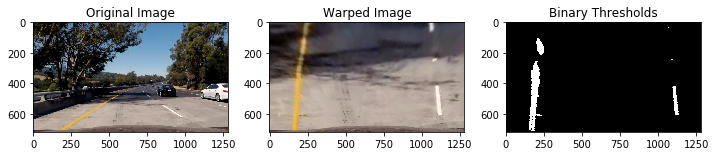

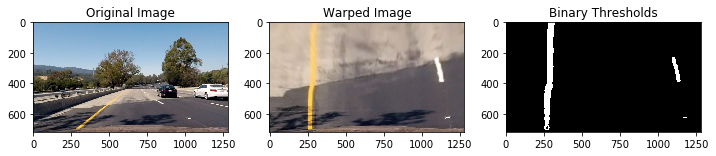

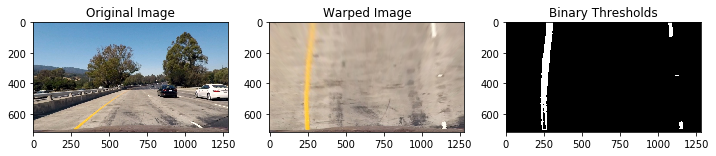

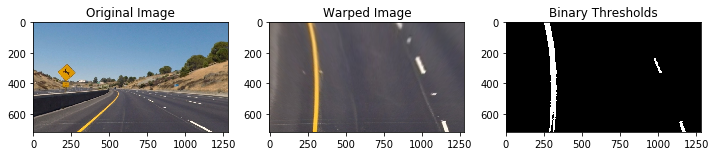

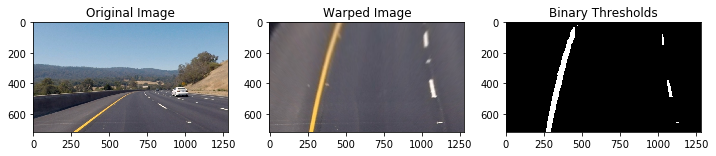

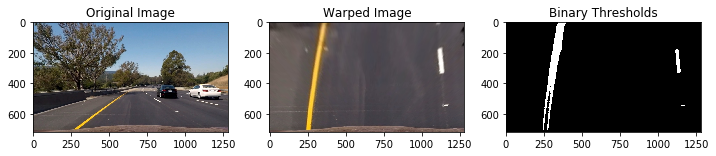

In [90]:
for image in glob.glob('test_images_in/test*.jpg'):
    apply_thresholds(image)

### Pipeline (single image) 3:

Example of image with perspective transform.

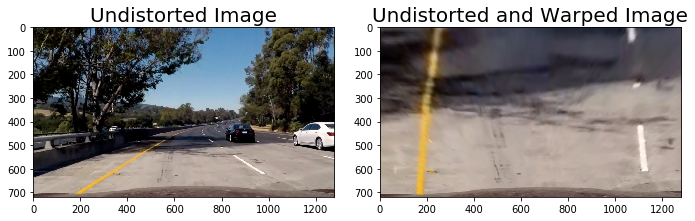

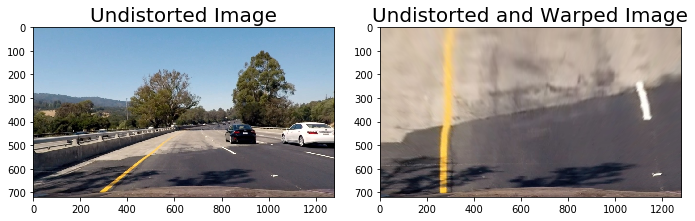

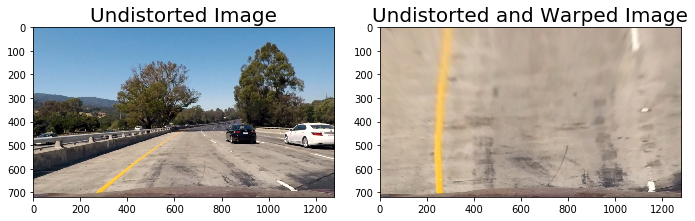

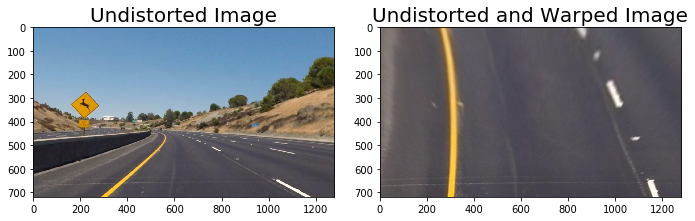

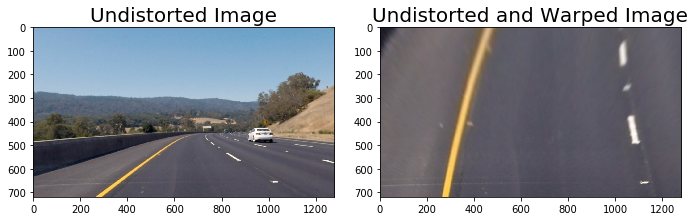

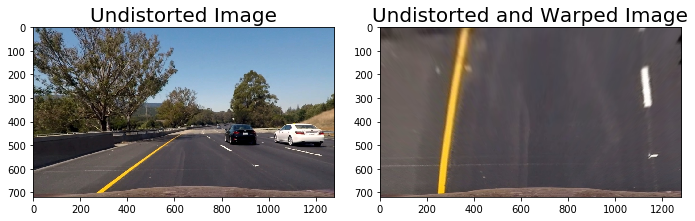

In [91]:
for image in glob.glob('test_images_in/test*.jpg'):
    birds_eye(image)

### Pipeline (single image) 4 & 5:

At this point I was able to use the combined binary image to isolate lane line pixels and fit a polynomial to each of the lane lines. The space in between the identified lane lines is filled in to highlight the driveable area in the lane. The position of the vehicle was measured by taking the average of the x intercepts of each line.



In the function `fill_lane()` below, lane lines are detected by identifying peaks in a histogram of the image and detecting nonzero pixels in close proximity to the peaks. 

Radius Calculation Function Reference:
http://www.intmath.com/applications-differentiation/8-radius-curvature.php

In [92]:
def fill_lane(image):
    
    combined_binary = apply_thresholds(image, show=False)
    
    rightx = []
    righty = []
    leftx = []
    lefty = []
     
    x, y = np.nonzero(np.transpose(combined_binary))
    i = 720
    j = 630
    while (j >= 0):
        histogram = np.sum(combined_binary[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    leftx = np.array(leftx).astype(np.float32)
    lefty = np.array(lefty).astype(np.float32)
    
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    #rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    rightx = np.append(rightx,right_fit[2])
    righty = np.append(righty, 0)
    
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    #leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    leftx = np.append(leftx,left_fit[2])
    lefty = np.append(lefty, 0)
    
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    
    righty = righty[rsort]
    rightx = rightx[rsort]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    # Measure Radius of Curvature for each lane line
    # meters per pixel in y dimension
    ym_per_pix = 30./720 
    
    # meteres per pixel in x dimension
    xm_per_pix = 3.7/700 
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    offset = 0 
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor((birds_eye(image, display=False)[0]), cv2.COLOR_BGR2RGB))
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(0, 720)
    ax1.plot(left_fitx, lefty, color='blue', linewidth=3)
    ax1.plot(right_fitx, righty, color='red', linewidth=3)
    ax1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
    ax1.invert_yaxis() # to visualize as we do the images
    ax2.imshow(result)
    ax2.set_title('Fill Lane Between Polynomials', fontsize=16)
    if center < 640:
        side = 'left'
    else:
        side = 'right'

    ax2.text(100, 125, 'Vehicle is {:.2f}m '.format(center*3.7/700) + side + ' of center', color='red', fontsize=8)
    ax2.text(100, 200, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)), color='red', fontsize=8)

### Pipeline (single image) 6:

Here are some examples of the polynomial fit and a clearly identified lane area.

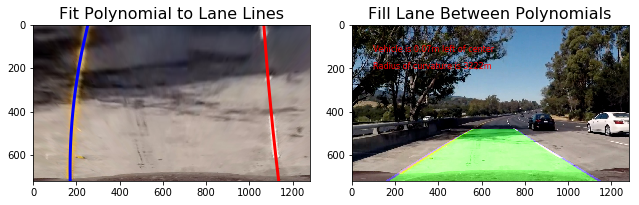

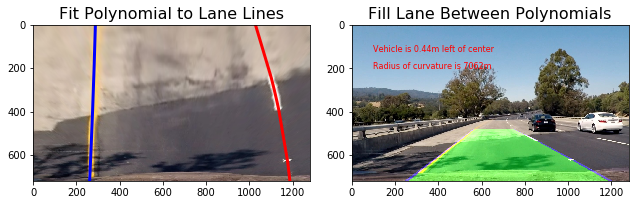

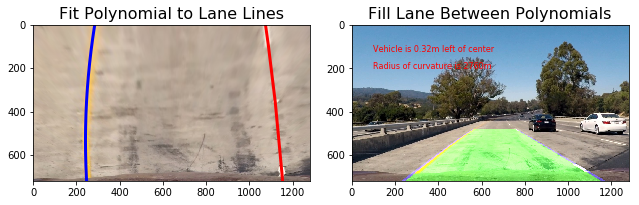

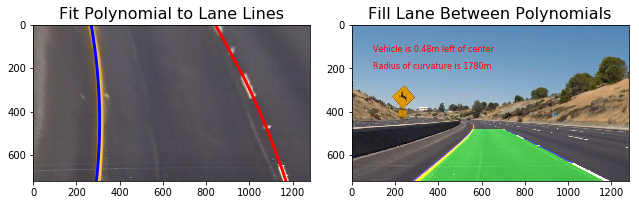

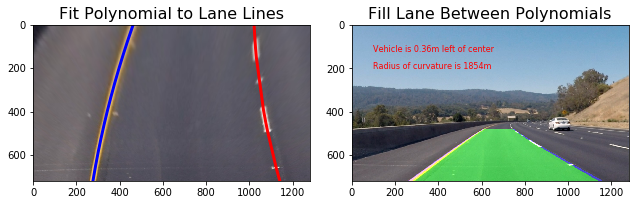

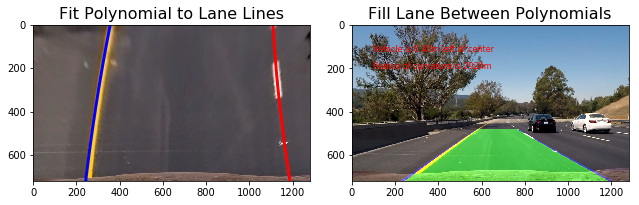

In [93]:
for image in glob.glob('test_images_in/test*.jpg'):
    fill_lane(image)

## Video Processing Pipeline:

First I am going to establish a class Line() for the lines to store attributes about the lane lines from one frame to the next. Inside the class I will define several functions which will be used to detect the pixels belonging to each lane line.

In [94]:
class Line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame and comparetors
        self.X = None
        self.Y = None
        self.last_x_int = None
        self.last_top = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
     
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit_0 = deque(maxlen=10)
        self.fit_1 = deque(maxlen=10)
        self.fit_2 = deque(maxlen=10)
        self.fit_x = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        x_vals = []
        y_vals = []
        if (self.found): 
            i = 720
            j = 630
            while j >= 0:
                y_val = np.mean([i,j])
                x_val = (np.mean(self.fit_0)) * y_val ** 2 + (np.mean(self.fit_1)) * y_val + (np.mean(self.fit_2))
                x_idx = np.where((((x_val - 25) < x) & (x < (x_val + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(x_vals, x_window)
                    np.append(y_vals, y_window)
                i -= 90
                j -= 90
        if (not np.sum(x_vals)) : 
            self.found = False # If no lane pixels were detected then perform blind search
        return x_vals, y_vals, self.found
    
    #lost_lines
    def blind_search(self, x, y, image):
        xvals = []
        yvals = []
        if (not self.found): 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, x_vals, y_vals):
        
        # meters per pixel in y dimension
        ym_per_pix = 30.0 / 720

        # meteres per pixel in x dimension
        xm_per_pix = 3.7 / 700 
        
        fit_cr = np.polyfit(y_vals * ym_per_pix, x_vals * xm_per_pix, 2)
        
        curve_in_rad = ((1 + (2 * fit_cr[0] * np.max(y_vals) + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])
        return curve_in_rad
    
    def sort_vals(self, x_vals, y_vals):
        sorted_index = np.argsort(y_vals)
        sorted_y_vals = y_vals[sorted_index]
        sorted_x_vals = x_vals[sorted_index]
        return sorted_x_vals, sorted_y_vals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0] * 720 ** 2 + polynomial[1] * 720 + polynomial[2]
        top = polynomial[2]
        return bottom, top

Next I create a function `process_vid()` which processes a video frame by frame and outputs an annotated video with lane lines, radius of curvature and distance from center.

The video processing pipeline is very similar to the `fill_lanes()` function established earlier in the report, except that the video pipeline stores information about the lane lines across frames to average the lane positions and ensure a smooth output which is less impacted by outliers.

The video pipeline also knows whether or not the lane line was detected in the previous frame, and if it was, it only checks for lane pixels in a tight window around the previous polynomial, ensuring a high confidence detection. If the lane line was not detected in the previous frames (and for the first 5 frames of the video) The pipeline performs the same search which was performed in the fill_lanes() function based on identifying peaks in a histogram.

In [96]:
# Video Processing Pipeline
def process_vid(image):
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perform perspective transform
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
  
    # Set the  thresholds for the l & b channels and combine
    
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[ (b_channel <= 200) & (b_channel >= 145) ] = 1
    
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    l_binary = np.zeros_like(l_channel)
    l_binary[ (l_channel <= 255) & (l_channel >= 215) ] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(b_binary == 1) | (l_binary == 1)] = 1
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if (Left.found): # Search for left lane pixels around previous polynomial
        left_x, left_y, Left.found = Left.found_search(x, y)
        
    if (Right.found): # Search for right lane pixels around previous polynomial
        right_x, right_y, Right.found = Right.found_search(x, y)

            
    if (not Right.found): # Perform blind search for right lane lines
        right_x, right_y, Right.found = Right.blind_search(x, y, combined_binary)
            
    if (not Left.found):# Perform blind search for left lane lines
        left_x, left_y, Left.found = Left.blind_search(x, y, combined_binary)

    left_y = np.array(left_y).astype(np.float32)
    left_x = np.array(left_x).astype(np.float32)
    right_y = np.array(right_y).astype(np.float32)
    right_x = np.array(right_x).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(left_y, left_x, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    left_x_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(left_x_int)
    Left.top.append(left_top)
    left_x_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.last_x_int = left_x_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    left_x = np.append(left_x, left_x_int)
    left_y = np.append(left_y, 720)
    left_x = np.append(left_x, left_top)
    left_y = np.append(left_y, 0)
    
    # Sort detected pixels based on the yvals
    left_x, left_y = Left.sort_vals(left_x, left_y)
    
    Left.X = left_x
    Left.Y = left_y
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(left_y, left_x, 2)
    Left.fit_0.append(left_fit[0])
    Left.fit_1.append(left_fit[1])
    Left.fit_2.append(left_fit[2])
    left_fit = [np.mean(Left.fit_0), 
                np.mean(Left.fit_1), 
                np.mean(Left.fit_2)]
    
    # Fit polynomial to detected pixels
    left_fit_x = left_fit[0] * left_y ** 2 + left_fit[1] * left_y + left_fit[2]
    Left.fit_x = left_fit_x
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(right_y, right_x, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    right_x_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(right_x_int)
    right_x_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.last_x_int = right_x_int
    Right.last_top = right_top
    right_x = np.append(right_x, right_x_int)
    right_y = np.append(right_y, 720)
    right_x = np.append(right_x, right_top)
    right_y = np.append(right_y, 0)
    
    # Sort right lane pixels
    right_x, right_y = Right.sort_vals(right_x, right_y)
    Right.X = right_x
    Right.Y = right_y
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(right_y, right_x, 2)
    Right.fit_0.append(right_fit[0])
    Right.fit_1.append(right_fit[1])
    Right.fit_2.append(right_fit[2])
    right_fit = [np.mean(Right.fit_0), np.mean(Right.fit_1), np.mean(Right.fit_2)]
    
    # Fit polynomial to detected pixels
    right_fit_x = right_fit[0] * right_y ** 2 + right_fit[1] * right_y + right_fit[2]
    Right.fit_x = right_fit_x
        
    # Compute radius of curvature for each lane in meters
    left_curve_in_rad = Left.radius_of_curvature(left_x, left_y)
    right_curve_in_rad = Right.radius_of_curvature(right_x, right_y)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if (Left.count % 3 == 0):
        Left.radius = left_curve_in_rad
        Right.radius = right_curve_in_rad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (right_x_int + left_x_int) / 2
    distance_from_center = abs((640 - position) * 3.7 / 700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fit_x, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fit_x, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    
    
    # Detect off center-ness
    if position > 640:
        side = "left"
    else:
        side = "right"
        
    # Print radius of curvature on video
    cv2.putText(result, 'Vehicle is {:.2f}m'.format(distance_from_center) + side +' of center', (100,80),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    Left.count += 1
    
    return result

In [98]:
Left = Line()
Right = Line()
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


  0%|          | 2/1261 [00:02<29:51,  1.42s/it]

KeyboardInterrupt: 